In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import euclidean_distances
from datetime import datetime
from scipy.cluster import hierarchy
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scipy.stats import boxcox
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from scipy.stats import ttest_ind
from scipy import stats

# Import data

In [41]:
#import data
Products=pd.read_excel("data/Products.xlsx")
Products.set_index('Cust_ID', inplace = True)
Products.head()

,Fitness&Gym,Hiking&Running,Last_Purchase,TeamGames,OutdoorActivities,TotalProducts
Cust_ID,,,,,,
4,0,76,2024-02-19,248,37,6
5,0,75,2024-02-17,248,37,6
6,6,69,2024-02-15,215,34,5
9,36,71,2024-02-13,248,35,8
10,8,97,2024-02-15,204,34,5


In [42]:
#search duplicates
len(Products[Products.duplicated()])

510

There are 510 duplicates.  

However, there is no reason to exclude them when the feedback we get is that the data's integrity is of the highst quality and all IDs (common with other two datasets are unique. It could be a specific promotion, for example.

In [43]:
#confirm uniqueness of IDs
len(Products.index.unique())

4000

In [44]:
#make column names better with snake_case
Products.columns = Products.columns.str.lower().str.replace('&','_')
Products.columns

Index(['fitness_gym', 'hiking_running', 'last_purchase', 'teamgames',
       'outdooractivities', 'totalproducts'],
      dtype='object')

# Exploration of the DF

In [45]:
Products.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4000 entries, 4 to 6496
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   fitness_gym        4000 non-null   int64         
 1   hiking_running     4000 non-null   int64         
 2   last_purchase      4000 non-null   datetime64[ns]
 3   teamgames          4000 non-null   int64         
 4   outdooractivities  4000 non-null   int64         
 5   totalproducts      4000 non-null   int64         
dtypes: datetime64[ns](1), int64(5)
memory usage: 347.8 KB


All value types seem correct. No null values.

In [46]:
Products.describe()

,fitness_gym,hiking_running,last_purchase,teamgames,outdooractivities,totalproducts
count,4000.000000,4000.000000,4000,4000.000000,4000.000000,4000.000000
mean,32.020250,55.844750,2024-01-30 18:50:02.399999744,176.085000,33.602750,5.329500
min,0.000000,9.000000,2023-10-15 00:00:00,0.000000,28.000000,2.000000
25%,25.000000,38.000000,2024-01-20 00:00:00,121.000000,32.000000,4.000000
50%,31.000000,47.000000,2024-02-01 00:00:00,180.000000,33.000000,5.000000
75%,40.000000,66.000000,2024-02-13 00:00:00,230.000000,35.000000,6.000000
max,123.000000,464.000000,2024-02-29 00:00:00,1203.000000,42.000000,20.000000
std,14.469284,33.119109,NaN,69.964738,1.711483,1.515257


All features have median and mean values close together, suggesting gaussian distribution data.  

Let's confirm.

In [47]:
#check skewness of data
numeric=['fitness_gym', 'hiking_running', 'teamgames', 'outdooractivities', 'totalproducts']
Products[numeric].skew()

fitness_gym          0.346342
hiking_running       4.671687
teamgames            0.740859
outdooractivities    0.414896
totalproducts        1.791119
dtype: float64

hiking_running and totalproducts  are highly positively skewed.  
teamgames is moderately skewed.


In [48]:
Products[numeric].kurt()

fitness_gym           1.464810
hiking_running       37.839539
teamgames            10.605494
outdooractivities     0.399144
totalproducts         9.247286
dtype: float64

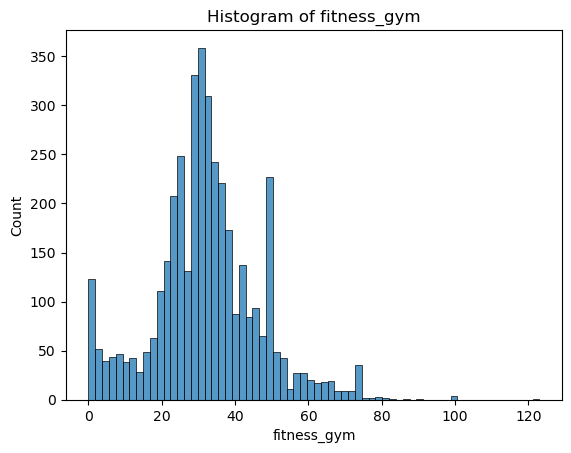

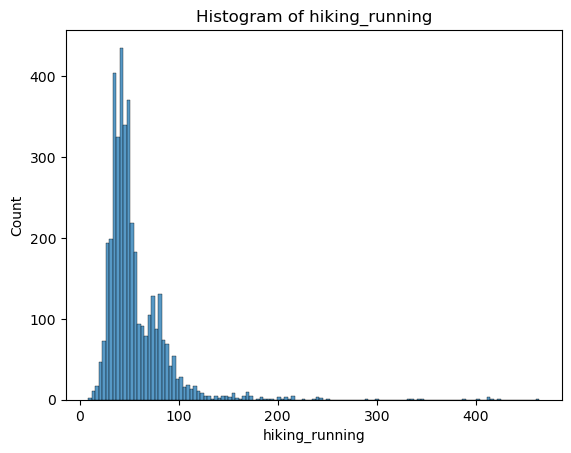

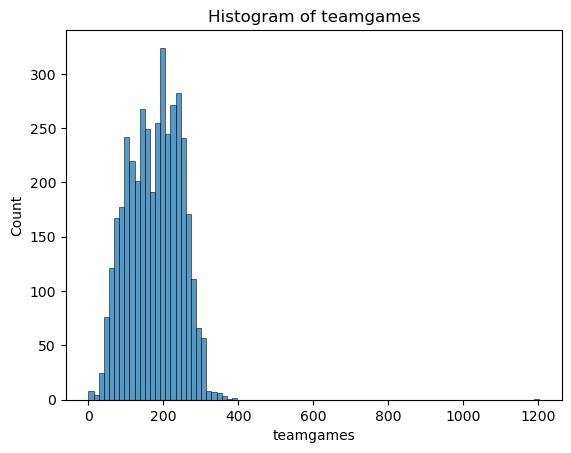

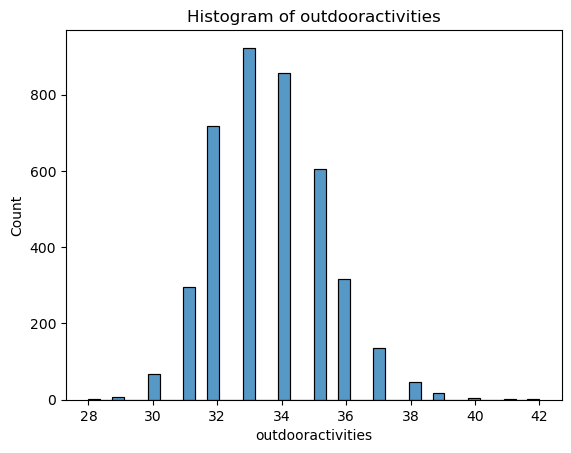

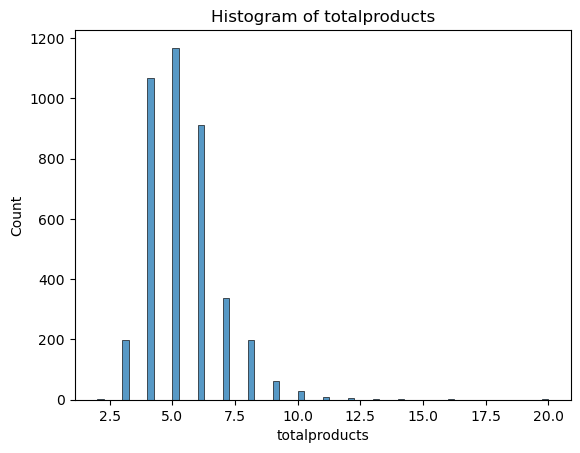

In [49]:
#check distributions
for column in Products[numeric].columns:
    sns.histplot(data=Products, x=column)
    plt.title(f'Histogram of {column}')
    plt.show()

# Preprocessing

No Df Products, criaremos:
1) Coluna de Total de Gasto,
2) Gasto médio por produto e
3) Trocamos data de última compra por #dias desde da última compra (assumindo 21-04-2024)
4) Removemos os duplicados
5) Deixar cair a coluna 'TotalProducts' porque não dá grande informação.

In [50]:
# Criar a nova coluna "total_spent" com a soma das colunas especificadas
spending=['fitness_gym', 'hiking_running', 'teamgames', 'outdooractivities']
Products['total_spent'] = Products[spending].sum(axis=1)
Products.head()                                                   

,fitness_gym,hiking_running,last_purchase,teamgames,outdooractivities,totalproducts,total_spent
Cust_ID,,,,,,,
4,0,76,2024-02-19,248,37,6,361
5,0,75,2024-02-17,248,37,6,360
6,6,69,2024-02-15,215,34,5,324
9,36,71,2024-02-13,248,35,8,390
10,8,97,2024-02-15,204,34,5,343


In [51]:
#criar coluna de average spending
Products['Avg_Spent']=Products['total_spent']/Products['totalproducts']
Products['Avg_Spent'] = np.ceil(Products['Avg_Spent'])  # Arredondar para cima
Products['Avg_Spent']=Products['Avg_Spent'].astype(int)
Products.head()

,fitness_gym,hiking_running,last_purchase,teamgames,outdooractivities,totalproducts,total_spent,Avg_Spent
Cust_ID,,,,,,,,
4,0,76,2024-02-19,248,37,6,361,61
5,0,75,2024-02-17,248,37,6,360,60
6,6,69,2024-02-15,215,34,5,324,65
9,36,71,2024-02-13,248,35,8,390,49
10,8,97,2024-02-15,204,34,5,343,69


In [52]:
#get number of days since last purchase
Products['last_purchase'] = pd.to_datetime(Products['last_purchase'])
today = pd.Timestamp(datetime.today().date())  # ou pd.Timestamp('today')
Products['Days_Since_Last_Purchase'] = (today - Products['last_purchase']).dt.days
Products.drop('last_purchase', axis=1, inplace=True)
Products.head()

,fitness_gym,hiking_running,teamgames,outdooractivities,totalproducts,total_spent,Avg_Spent,Days_Since_Last_Purchase
Cust_ID,,,,,,,,
4,0,76,248,37,6,361,61,68
5,0,75,248,37,6,360,60,70
6,6,69,215,34,5,324,65,72
9,36,71,248,35,8,390,49,74
10,8,97,204,34,5,343,69,72


## DEA

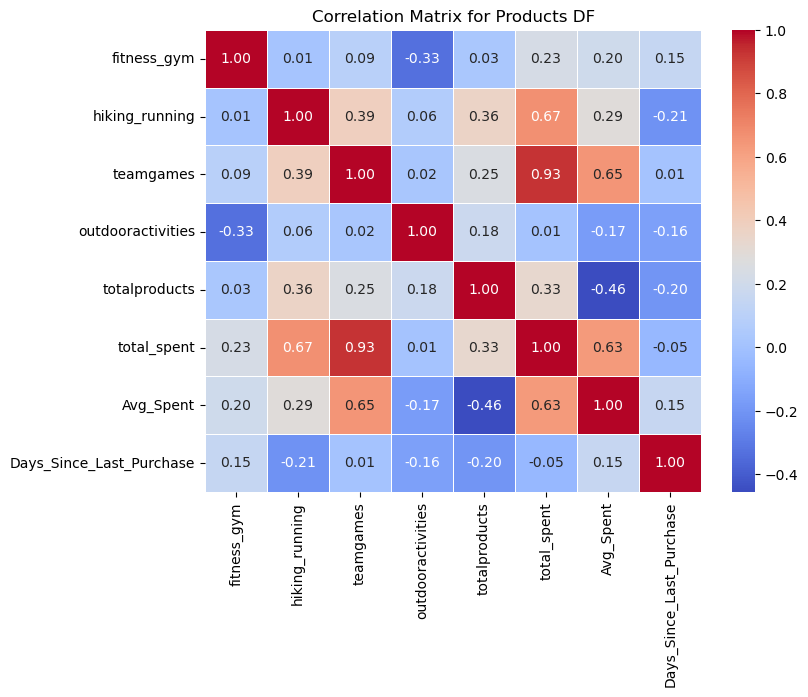

In [53]:
# Calcular a matriz de correlação
correlation_matrix_Products = Products.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix_Products, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix for Products DF')
plt.show() #Vejo correlação mt forte entre Total_Expensed e TeamGames

No high correlations, except 'teamgames' vs 'total_spent', since teamgames influence highly the amount spent due to the high values involved.

# outliers
### Delete outliers and rerun scaling
- For each column determine the Q3 + 1.5xQ3 and
- then exclude the outliers

**on the original data**

### Q3 + 1.5xIQR technique - removes almost 25% of the data

In [54]:
#get Q3 (75% quantile)
statiscs_table=Products.describe()
statistics_quantiles = statiscs_table.loc[['25%','75%'],:].transpose()
statistics_quantiles

,25%,75%
fitness_gym,25.0,40.0
hiking_running,38.0,66.0
teamgames,121.0,230.0
outdooractivities,32.0,35.0
totalproducts,4.0,6.0
total_spent,227.0,363.0
Avg_Spent,45.0,70.0
Days_Since_Last_Purchase,74.0,98.0


In [55]:
#create interquantile range (Q1-Q3)
statistics_quantiles['IQR'] = statistics_quantiles['75%'] - statistics_quantiles['25%']

In [56]:
#calculate Q3+1.5xIQR
statistics_quantiles['outlier'] = statistics_quantiles['75%'] + statistics_quantiles['IQR']
statistics_quantiles = statistics_quantiles.transpose()
statistics_quantiles

,fitness_gym,hiking_running,teamgames,outdooractivities,totalproducts,total_spent,Avg_Spent,Days_Since_Last_Purchase
25%,25.0,38.0,121.0,32.0,4.0,227.0,45.0,74.0
75%,40.0,66.0,230.0,35.0,6.0,363.0,70.0,98.0
IQR,15.0,28.0,109.0,3.0,2.0,136.0,25.0,24.0
outlier,55.0,94.0,339.0,38.0,8.0,499.0,95.0,122.0


In [57]:
#filter df according to filters above
Products_clean = Products.copy()
for feature in statistics_quantiles.columns:
    Products_clean = Products_clean[Products_clean[feature] < statistics_quantiles.loc['outlier', feature]]

Products_clean.describe()

,fitness_gym,hiking_running,teamgames,outdooractivities,totalproducts,total_spent,Avg_Spent,Days_Since_Last_Purchase
count,3047.000000,3047.000000,3047.000000,3047.000000,3047.000000,3047.000000,3047.000000,3047.000000
mean,29.996390,48.522153,163.469642,33.565146,5.025271,275.553331,56.569413,86.709879
std,11.378854,16.882626,64.594825,1.580289,1.037234,75.492507,15.763134,14.704571
min,0.000000,12.000000,0.000000,28.000000,3.000000,66.000000,14.000000,59.000000
25%,25.000000,36.000000,110.000000,32.000000,4.000000,214.000000,45.000000,75.000000
50%,30.000000,45.000000,162.000000,33.000000,5.000000,273.000000,56.000000,86.000000
75%,37.000000,56.000000,215.000000,35.000000,6.000000,335.000000,68.000000,97.000000
max,54.000000,93.000000,327.000000,37.000000,7.000000,475.000000,94.000000,121.000000


### 3x Z-scores - 190 datapoints eliminated

In [58]:
Products_cleanzscores = Products.copy()
z_scores = np.abs(stats.zscore(Products))

In [59]:
Products_cleanzscores = Products_cleanzscores[(z_scores < 3).all(axis=1)]
Products_cleanzscores.describe()

,fitness_gym,hiking_running,teamgames,outdooractivities,totalproducts,total_spent,Avg_Spent,Days_Since_Last_Purchase
count,3810.000000,3810.000000,3810.000000,3810.000000,3810.000000,3810.000000,3810.000000,3810.000000
mean,31.675591,52.458530,174.239108,33.596325,5.234908,291.969554,58.218898,86.995276
std,13.826220,21.255277,67.867288,1.644992,1.288595,82.799299,17.785037,16.181774
min,0.000000,9.000000,0.000000,29.000000,2.000000,62.000000,12.000000,58.000000
25%,25.000000,38.000000,119.000000,32.000000,4.000000,225.000000,45.000000,74.000000
50%,31.000000,47.000000,178.000000,34.000000,5.000000,294.000000,57.000000,86.000000
75%,39.000000,62.000000,228.000000,35.000000,6.000000,358.000000,70.000000,98.000000
max,75.000000,152.000000,372.000000,38.000000,9.000000,547.000000,115.000000,138.000000


In [60]:
Products_cleanzscores = Products_cleanzscores.dropna()
print(f'ekiminated entries: {4000-len(Products_cleanzscores)}')

ekiminated entries: 190


### 99 percentile technique - 299 entries eliminated

In [21]:
#make copy
Products_clean99quantile = Products.copy()
upper_limit = Products_clean99quantile.quantile(0.99)
upper_limit

fitness_gym                  74.00
hiking_running              179.05
teamgames                   309.01
outdooractivities            38.00
totalproducts                10.00
total_spent                 510.03
Avg_Spent                   107.00
Days_Since_Last_Purchase    131.01
Name: 0.99, dtype: float64

In [22]:
#get clean df
Products_clean99quantile = Products_clean99quantile[Products_clean99quantile < upper_limit]
Products_clean99quantile.describe()

,fitness_gym,hiking_running,teamgames,outdooractivities,totalproducts,total_spent,Avg_Spent,Days_Since_Last_Purchase
count,3955.000000,3960.000000,3960.000000,3929.000000,3944.000000,3960.000000,3957.000000,3960.000000
mean,31.483944,53.675253,174.276768,33.514126,5.242394,294.231566,58.036644,86.625758
std,13.601356,23.747463,66.534296,1.589126,1.303176,83.452895,17.893911,16.050213
min,0.000000,9.000000,0.000000,28.000000,2.000000,62.000000,12.000000,58.000000
25%,25.000000,38.000000,120.000000,32.000000,4.000000,227.000000,45.000000,74.000000
50%,31.000000,47.000000,178.000000,33.000000,5.000000,296.500000,57.000000,85.000000
75%,39.000000,64.000000,229.000000,35.000000,6.000000,361.000000,70.000000,98.000000
max,73.000000,179.000000,309.000000,37.000000,9.000000,510.000000,106.000000,131.000000


Different number of entries are eliminated.

array([[<Axes: title={'center': 'fitness_gym'}>,
        <Axes: title={'center': 'hiking_running'}>,
        <Axes: title={'center': 'teamgames'}>],
       [<Axes: title={'center': 'outdooractivities'}>,
        <Axes: title={'center': 'totalproducts'}>,
        <Axes: title={'center': 'total_spent'}>],
       [<Axes: title={'center': 'Avg_Spent'}>,
        <Axes: title={'center': 'Days_Since_Last_Purchase'}>, <Axes: >]],
      dtype=object)

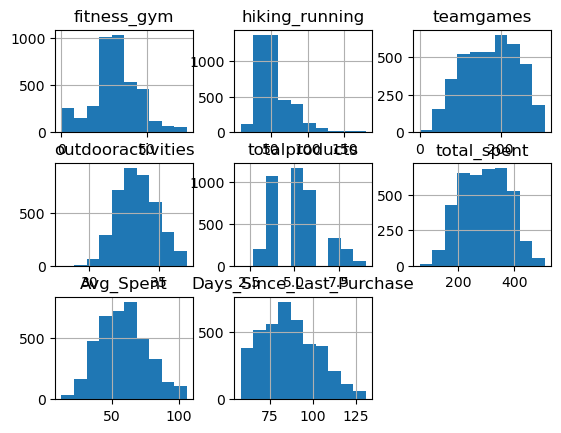

In [23]:
Products_clean99quantile.hist()

- Better distributions 
- but eliminated values even if they were not far away
- created some null values

In [24]:
print('length of df: ', len(Products_clean99quantile))
print('remanining null values:')
Products_clean99quantile.isna().sum()

length of df:  4000
remanining null values:


fitness_gym                 45
hiking_running              40
teamgames                   40
outdooractivities           71
totalproducts               56
total_spent                 40
Avg_Spent                   43
Days_Since_Last_Purchase    40
dtype: int64

Maximum of eliminated entries would be 71.

In [39]:
Products_clean99quantile = Products_clean99quantile.dropna()
print(f'ekiminated entries: {4000-len(Products_clean99quantile)}')

ekiminated entries: 299


### 99percentile and zscore rule - 132 entries deleted (99percentile & 4xzscore - 64 entries eliminated)

In [72]:
Products_clean99andZscore = Products.copy()

#Calculate Z-scores for each feature
z_scores = np.abs(stats.zscore(Products_clean99andZscore))

# Convert Z-scores into a DataFrame for easier handling
z_scores_df = pd.DataFrame(z_scores, columns=Products_clean99andZscore.columns, index=Products_clean99andZscore.index)

# Create a mask for Z-scores greater than 3
zscore_mask = z_scores_df > 3

# Step 3: Apply both filters
# Create a mask for values above the 99th percentile
upper_limit = Products.quantile(0.99)
quantile_mask = Products > upper_limit

#combined mask
combined_mask = zscore_mask & quantile_mask 


#filter
Products_clean99andZscore = Products[~combined_mask]

Products_clean99andZscore.describe()


,fitness_gym,hiking_running,teamgames,outdooractivities,totalproducts,total_spent,Avg_Spent,Days_Since_Last_Purchase
count,3984.000000,3960.000000,3999.000000,3976.000000,3974.000000,3976.000000,3980.000000,3981.000000
mean,31.793675,53.675253,175.828207,33.567153,5.278309,295.184105,58.338442,86.879176
std,14.026287,23.747463,68.062122,1.652448,1.362009,84.629515,18.277022,16.382357
min,0.000000,9.000000,0.000000,28.000000,2.000000,62.000000,12.000000,58.000000
25%,25.000000,38.000000,121.000000,32.000000,4.000000,227.000000,45.000000,74.000000
50%,31.000000,47.000000,180.000000,33.000000,5.000000,297.000000,57.000000,85.000000
75%,39.000000,64.000000,229.500000,35.000000,6.000000,362.000000,70.000000,98.000000
max,75.000000,179.000000,384.000000,38.000000,10.000000,567.000000,115.000000,138.000000


In [73]:
Products_clean99andZscore.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4000 entries, 4 to 6496
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   fitness_gym               3984 non-null   float64
 1   hiking_running            3960 non-null   float64
 2   teamgames                 3999 non-null   float64
 3   outdooractivities         3976 non-null   float64
 4   totalproducts             3974 non-null   float64
 5   total_spent               3976 non-null   float64
 6   Avg_Spent                 3980 non-null   float64
 7   Days_Since_Last_Purchase  3981 non-null   float64
dtypes: float64(8)
memory usage: 410.3 KB


In [74]:
Products_clean99andZscore.isna().sum()

fitness_gym                 16
hiking_running              40
teamgames                    1
outdooractivities           24
totalproducts               26
total_spent                 24
Avg_Spent                   20
Days_Since_Last_Purchase    19
dtype: int64

Deletes between 1 and 40 entries which is an aceptable number (may be more when combined)

In [75]:
Products_clean99andZscore = Products_clean99andZscore.dropna()
Products_clean99andZscore.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3868 entries, 4 to 6496
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   fitness_gym               3868 non-null   float64
 1   hiking_running            3868 non-null   float64
 2   teamgames                 3868 non-null   float64
 3   outdooractivities         3868 non-null   float64
 4   totalproducts             3868 non-null   float64
 5   total_spent               3868 non-null   float64
 6   Avg_Spent                 3868 non-null   float64
 7   Days_Since_Last_Purchase  3868 non-null   float64
dtypes: float64(8)
memory usage: 272.0 KB


In [76]:
print(f'% of deleted entries: {(4000-len(Products_clean99andZscore))/4000*100:.1f}')
print(f'deleted entries: {4000-len(Products_clean99andZscore)}')

% of deleted entries: 3.3
deleted entries: 132


### 4x ZScores - eliminated 64 entries

In [64]:
Products_cleanzscoresextra = Products.copy()
z_scores = np.abs(stats.zscore(Products_cleanzscoresextra))

In [65]:
Products_cleanzscoresextra = Products_cleanzscoresextra[(z_scores < 4).all(axis=1)]
Products_cleanzscoresextra.describe()

,fitness_gym,hiking_running,teamgames,outdooractivities,totalproducts,total_spent,Avg_Spent,Days_Since_Last_Purchase
count,3936.000000,3936.000000,3936.000000,3936.000000,3936.000000,3936.000000,3936.000000,3936.000000
mean,31.845528,53.717988,175.089431,33.611280,5.283537,294.264228,58.451220,87.104675
std,14.148586,23.977642,67.906548,1.695593,1.380530,84.023496,18.489453,16.587643
min,0.000000,9.000000,0.000000,28.000000,2.000000,62.000000,12.000000,58.000000
25%,25.000000,38.000000,120.000000,32.000000,4.000000,226.000000,45.000000,74.000000
50%,31.000000,47.000000,178.000000,33.500000,5.000000,296.000000,57.000000,86.000000
75%,39.000000,64.000000,229.000000,35.000000,6.000000,361.000000,70.000000,98.000000
max,86.000000,186.000000,372.000000,40.000000,11.000000,573.000000,133.000000,155.000000


In [159]:
Products_cleanzscoresextra = Products_cleanzscoresextra.dropna()
print(f'eliminated entries: {4000-len(Products_cleanzscoresextra)}')

eliminated entries: 64


### clean df

In [82]:
Products_clean = Products_cleanzscoresextra
Products_clean.head()

,fitness_gym,hiking_running,teamgames,outdooractivities,totalproducts,total_spent,Avg_Spent,Days_Since_Last_Purchase
Cust_ID,,,,,,,,
4,0,76,248,37,6,361,61,68
5,0,75,248,37,6,360,60,70
6,6,69,215,34,5,324,65,72
9,36,71,248,35,8,390,49,74
10,8,97,204,34,5,343,69,72


# Transform

#scaling
scaler = StandardScaler()
Products_scaled = pd.DataFrame(scaler.fit_transform(Products_clean), columns = Products.columns) #applied to all columns because all are numeric
Products_scaled = Products_scaled.drop('total_spent', axis=1) #because of high correlation to teamgames
Products_scaled.head()

#check data variability
sns.boxplot(data=Products_scaled)
plt.xticks(rotation=90)
plt.show() 

In [87]:
#get IDs
ids = Products_clean.index

array([[<Axes: title={'center': 'fitness_gym'}>,
        <Axes: title={'center': 'hiking_running'}>,
        <Axes: title={'center': 'teamgames'}>],
       [<Axes: title={'center': 'outdooractivities'}>,
        <Axes: title={'center': 'totalproducts'}>,
        <Axes: title={'center': 'total_spent'}>],
       [<Axes: title={'center': 'Avg_Spent'}>,
        <Axes: title={'center': 'Days_Since_Last_Purchase'}>, <Axes: >]],
      dtype=object)

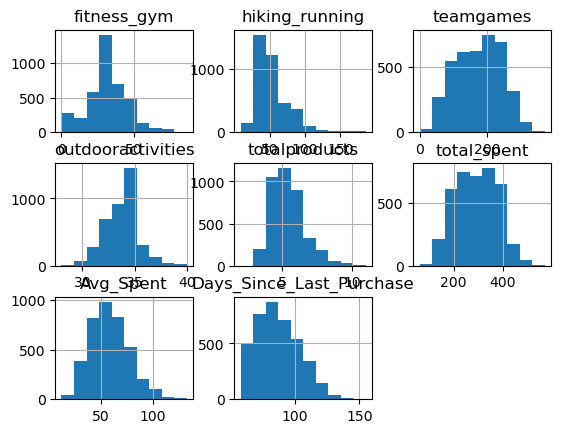

In [88]:
Products_clean.hist()

In [92]:
#skewness
print('original skewness')
display(Products.skew())
print('cleaned skewness')
Products_clean.skew()

original skewness


fitness_gym                 0.346342
hiking_running              4.671687
teamgames                   0.740859
outdooractivities           0.414896
totalproducts               1.791119
total_spent                 0.829234
Avg_Spent                   0.559660
Days_Since_Last_Purchase    0.715300
dtype: float64

cleaned skewness


fitness_gym                 0.185997
hiking_running              1.746290
teamgames                  -0.045738
outdooractivities           0.354366
totalproducts               0.848180
total_spent                 0.073696
Avg_Spent                   0.457438
Days_Since_Last_Purchase    0.510210
dtype: float64

**Great improvement in skewness.** 

**Transform all with skewness above 0.5.**


### Hiking_running

In [93]:
# Applying Transformations to hiking_running
hiking_running_log = np.log(Products_clean.hiking_running)
hiking_running_sqrt = np.sqrt(Products_clean.hiking_running)
hiking_running_cbrt = np.cbrt(Products_clean.hiking_running)

print(f'Skewness of original data: {Products_clean.hiking_running.skew():.5f}')
print(f'Skewness after Log Transformation: {hiking_running_log.skew():.5f}')
print(f'Skewness after Square Root Transformation: {hiking_running_sqrt.skew():.5f}')
print(f'Skewness after Cubic Root Transformation: {hiking_running_cbrt.skew():.5f}')

Skewness of original data: 1.74629
Skewness after Log Transformation: 0.36105
Skewness after Square Root Transformation: 1.01750
Skewness after Cubic Root Transformation: 0.79611


In [94]:
# Applying Box-Cox Transformation after checking all values are positive
if (Products_clean.hiking_running > 0).all(): #needs all values to be positive
    hiking_running_boxcox, _ = boxcox(Products_clean.hiking_running)
    hiking_running_boxcox = pd.Series(hiking_running_boxcox)
else:
    # Consider alternative transformations or handling strategies
    print("Not all SalePrice values are positive. Consider using Yeo-Johnson or handling negative values.")
print(f"Skewness after Box-Cox Transformation: {hiking_running_boxcox.skew():.5f}")

Skewness after Box-Cox Transformation: -0.01312


<Axes: >

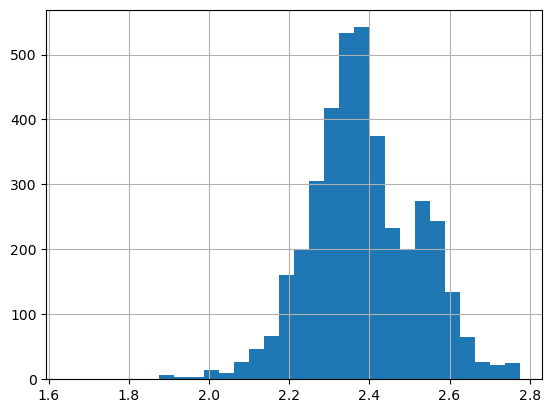

In [95]:
#check box cox transform
hiking_running_boxcox.hist(bins=30)

<Axes: >

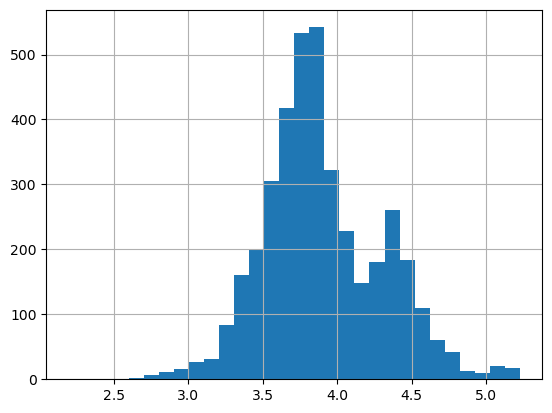

In [96]:
#check log transform
hiking_running_log.hist(bins=30)

Similar. Box Cox transform is better: lower skewness value.
However Box Cox insert empty values to df, so we will use Log method.

In [97]:
#apply to original dataset
Products_trans = Products_clean.copy()
Products_trans.hiking_running = hiking_running_log

### totalproducts

In [98]:
# Applying Transformations to hiking_running
totalproducts_log = np.log(Products_clean.totalproducts)
totalproducts_sqrt = np.sqrt(Products_clean.totalproducts)
totalproducts_cbrt = np.cbrt(Products_clean.totalproducts)

print(f'Skewness of original data: {Products_clean.totalproducts.skew():.5f}')
print(f'Skewness after Log Transformation: {totalproducts_log.skew():.5f}')
print(f'Skewness after Square Root Transformation: {totalproducts_sqrt.skew():.5f}')
print(f'Skewness after Cubic Root Transformation: {totalproducts_cbrt.skew():.5f}')

Skewness of original data: 0.84818
Skewness after Log Transformation: 0.09908
Skewness after Square Root Transformation: 0.46847
Skewness after Cubic Root Transformation: 0.34485


De novo, Log apresenta boa transformação levando a um skewness reduzido.

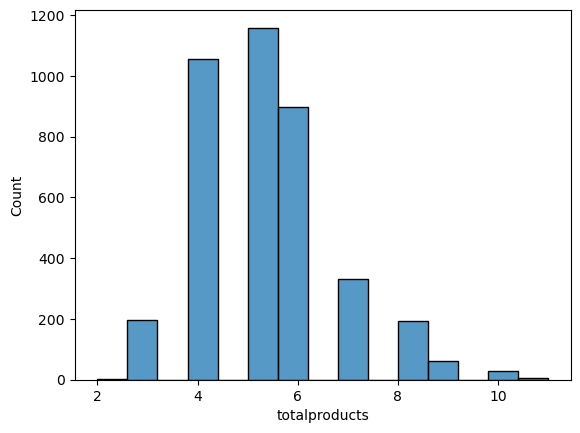

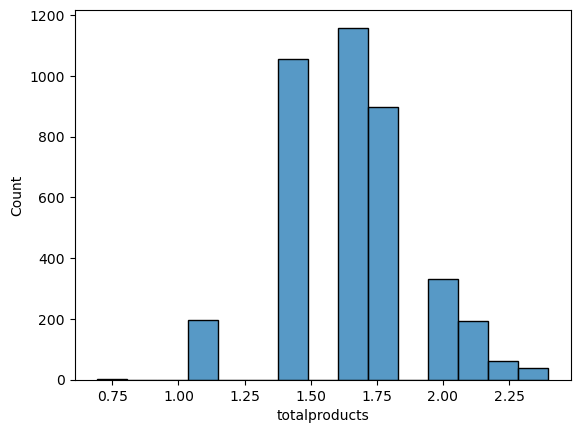

In [99]:
sns.histplot(Products_clean.totalproducts, bins=15)
plt.show()
sns.histplot(totalproducts_log, bins=15)
plt.show()

In [100]:
#transform df
Products_trans.totalproducts = totalproducts_log

# Saling on transformed data

In [109]:
#run scaling
scaler = StandardScaler()
Products_trans_scaled = pd.DataFrame(scaler.fit_transform(Products_trans), columns = Products_trans.columns) #applied to all columns because all are numeric
Products_trans_scaled = Products_trans_scaled.drop('total_spent', axis=1) #because of high correlation to teamgames
Products_trans_scaled.index = Products_trans.index
Products_trans_scaled.head()

,fitness_gym,hiking_running,teamgames,outdooractivities,totalproducts,Avg_Spent,Days_Since_Last_Purchase
Cust_ID,,,,,,,
4,-2.251078,1.082187,1.073826,1.998800,0.628263,0.137868,-1.151888
5,-2.251078,1.048844,1.073826,1.998800,0.628263,0.083776,-1.031301
6,-1.826954,0.838944,0.587803,0.229282,-0.088779,0.354235,-0.910714
9,0.293669,0.910873,1.073826,0.819121,1.759670,-0.511233,-0.790127
10,-1.685579,1.696361,0.425795,0.229282,-0.088779,0.570602,-0.910714


In [110]:
Products_trans_scaled.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3936 entries, 4 to 6496
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   fitness_gym               3936 non-null   float64
 1   hiking_running            3936 non-null   float64
 2   teamgames                 3936 non-null   float64
 3   outdooractivities         3936 non-null   float64
 4   totalproducts             3936 non-null   float64
 5   Avg_Spent                 3936 non-null   float64
 6   Days_Since_Last_Purchase  3936 non-null   float64
dtypes: float64(7)
memory usage: 246.0 KB


# kmeans clustering

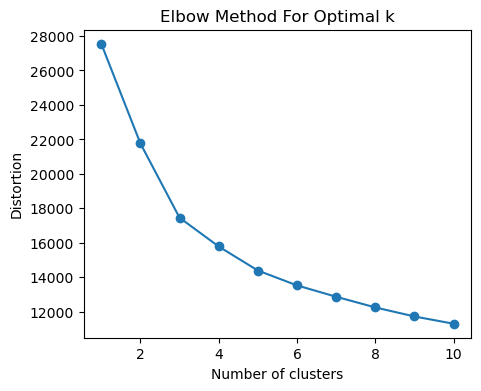

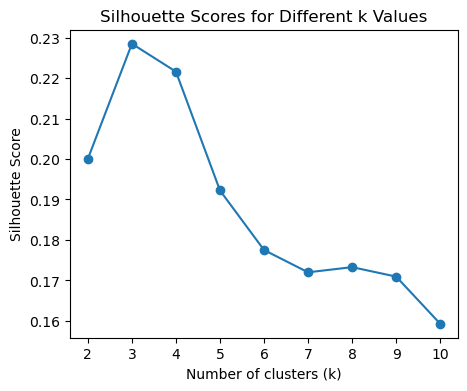

In [111]:
# Calculate distortion for a range of number of cluster
distortions = [] #for elbow method

#for silhouette method
features = Products_trans_scaled
silhouette_scores = []

#calculate relevant measurements for both elbow and silhouette methods
for i in range(1, 11):
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=300, random_state=42) #kmean++ to get a better spreading of the initial centroids
    cluster_labels = km.fit_predict(features)  # Fit and predict simultaneously
    #calculate inertia score
    distortions.append(km.inertia_)

    # Calculate silhouette scores
    if i > 1:
        silhouette_avg = silhouette_score(features, cluster_labels)
        silhouette_scores.append(silhouette_avg)

# Plot the elbow graph
plt.figure(figsize=(5, 4))
plt.plot(range(1, 11), distortions, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

# Plot the silhouette scores, note the range adjustment for x-axis
if len(silhouette_scores) > 0:  # Check if list is not empty
    plt.figure(figsize=(5, 4))
    plt.plot(range(2, 11), silhouette_scores, marker='o')
    plt.title('Silhouette Scores for Different k Values')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.show()

### Conclusion on clusters
- elbow method not clear on the best number of cluster with a smooth curve
- silhuette method suggests 3 clusters, followed by 4, then by 2.

We will get **3** clusters first. Depending on difficulties in interpreting the data, we may go to 2.

In [112]:
#save model and assign clusters
n_clusters=3
km = KMeans(n_clusters=n_clusters, init='k-means++', n_init=10, max_iter=300, random_state=42)
km.fit(Products_trans_scaled) #create model
clusters = km.labels_ #assign clusters

## Assigning labels to datasets

In [113]:
#Products transformed e scaled
Products_trans_scaled['cluster_label']=clusters

Products_trans_scaled.head()

,fitness_gym,hiking_running,teamgames,outdooractivities,totalproducts,Avg_Spent,Days_Since_Last_Purchase,cluster_label
Cust_ID,,,,,,,,
4,-2.251078,1.082187,1.073826,1.998800,0.628263,0.137868,-1.151888,0
5,-2.251078,1.048844,1.073826,1.998800,0.628263,0.083776,-1.031301,0
6,-1.826954,0.838944,0.587803,0.229282,-0.088779,0.354235,-0.910714,0
9,0.293669,0.910873,1.073826,0.819121,1.759670,-0.511233,-0.790127,0
10,-1.685579,1.696361,0.425795,0.229282,-0.088779,0.570602,-0.910714,0


In [126]:
#Products original (menos outliers)
Products_final = Products.loc[Products_trans_scaled.index]
Products_final['cluster_label']= clusters #assign clusters to df
Products_final.drop('total_spent', axis=1, inplace=True)
Products_final.head()

,fitness_gym,hiking_running,teamgames,outdooractivities,totalproducts,Avg_Spent,Days_Since_Last_Purchase,cluster_label
Cust_ID,,,,,,,,
4,0,76,248,37,6,61,68,0
5,0,75,248,37,6,60,70,0
6,6,69,215,34,5,65,72,0
9,36,71,248,35,8,49,74,0
10,8,97,204,34,5,69,72,0


In [127]:
Products_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3936 entries, 4 to 6496
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype
---  ------                    --------------  -----
 0   fitness_gym               3936 non-null   int64
 1   hiking_running            3936 non-null   int64
 2   teamgames                 3936 non-null   int64
 3   outdooractivities         3936 non-null   int64
 4   totalproducts             3936 non-null   int64
 5   Avg_Spent                 3936 non-null   int32
 6   Days_Since_Last_Purchase  3936 non-null   int64
 7   cluster_label             3936 non-null   int32
dtypes: int32(2), int64(6)
memory usage: 246.0 KB


# Export DFs

In [131]:
#export final df with original cleaned data and a column with clusters
Products_final.to_csv('exported_data/Product_clustered.csv', index=True) #includes indices

#then import with:
#pd.read_csv('exported_data/Product_clustered.csv', index_col=0)

# Clusters analysis

In [132]:
#count entries in each cluster
Products_final.groupby('cluster_label').cluster_label.count().transpose()

cluster_label
0    1114
1    1230
2    1592
Name: cluster_label, dtype: int64

In [133]:
#look at means
Products_final.groupby('cluster_label').mean().transpose()

cluster_label,0,1,2
fitness_gym,26.268402,37.223577,31.592965
hiking_running,77.332136,52.682114,37.994347
teamgames,218.937163,217.892683,111.336683
outdooractivities,34.793537,32.767480,33.435930
totalproducts,6.358169,4.548780,5.099246
Avg_Spent,58.156194,77.024390,44.307789
Days_Since_Last_Purchase,74.517953,98.570732,87.053392


Análise dos 3 clusters em curso  

1114, 1230, 1592 – boa divisão  


in order:
fitness_gym:..............1 2 0  
hiking_running:...........0 1 2  
teamgames:................0+1 2  
outdooractivities:........  =  
totalproducts:............  
Avg_spent:................1 0 2  
Days_Since_Last_Purchase: 1 2 0  

cluster 0:
- buyer of hiking_running and teamgames
- medium spent money and medium buying frequency

cluster 1:
- buys more expensive products
- fitness & gym best buyer
- takes longer to return to store

cluster 2
- goes more freuqently
- buys cheaper items

### Days_Since_Last_Purchase

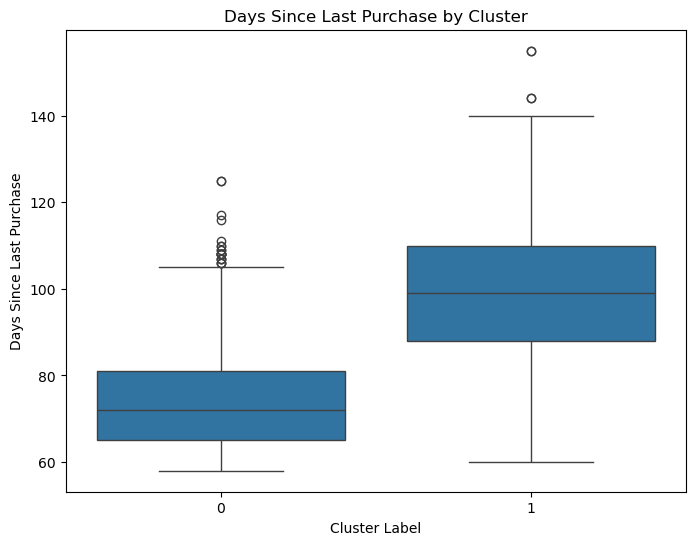

In [136]:
#Products.query("cluster_label == 0")['Days_Since_Last_Purchase'].plot())

# Filtering data for cluster_label == 0
data = Products_final[Products_final['cluster_label'].isin([0, 1])]

# Create a boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(data=data, x='cluster_label', y='Days_Since_Last_Purchase')
plt.title('Days Since Last Purchase by Cluster')
plt.xlabel('Cluster Label')
plt.ylabel('Days Since Last Purchase')
plt.show()


In [137]:
#statistics
feature = 'Days_Since_Last_Purchase'
# Extracting data for each cluster
cluster_0_data = Products_final.query("cluster_label == 0")[feature]
cluster_1_data = Products_final.query("cluster_label == 1")[feature]

# Performing the t-test
t_stat, p_value = ttest_ind(cluster_0_data, cluster_1_data, equal_var=False)

# Printing the results
print("T-statistic:", t_stat)
print("P-value:", p_value)

T-statistic: -42.77132805866067
P-value: 1.7052759436493478e-292


**They are statistically significant**

### fitness_gym

In [138]:
#statistics
feature = 'fitness_gym'
# Extracting data for each cluster
cluster_0_data = Products_final.query("cluster_label == 0")[feature]
cluster_2_data = Products_final.query("cluster_label == 2")[feature]

# Performing the t-test
t_stat, p_value = ttest_ind(cluster_0_data, cluster_2_data, equal_var=False)

# Printing the results
print("T-statistic:", t_stat)
print("P-value:", p_value)

T-statistic: -9.271075797481245
P-value: 5.787250766446733e-20


**fitness_gym is statistically different**

### hiking_running

In [139]:
#statistics
feature = 'hiking_running'
# Extracting data for each cluster
cluster_0_data = Products_final.query("cluster_label == 0")[feature]
cluster_2_data = Products_final.query("cluster_label == 2")[feature]

# Performing the t-test
t_stat, p_value = ttest_ind(cluster_0_data, cluster_2_data, equal_var=False)

# Printing the results
print("T-statistic:", t_stat)
print("P-value:", p_value)

T-statistic: 55.52449465698657
P-value: 0.0


**hiking_running is statistically different**

# PCA visualization

In [150]:
Products_trans_scaled.head()

,fitness_gym,hiking_running,teamgames,outdooractivities,totalproducts,Avg_Spent,Days_Since_Last_Purchase,cluster_label
Cust_ID,,,,,,,,
4,-2.251078,1.082187,1.073826,1.998800,0.628263,0.137868,-1.151888,0
5,-2.251078,1.048844,1.073826,1.998800,0.628263,0.083776,-1.031301,0
6,-1.826954,0.838944,0.587803,0.229282,-0.088779,0.354235,-0.910714,0
9,0.293669,0.910873,1.073826,0.819121,1.759670,-0.511233,-0.790127,0
10,-1.685579,1.696361,0.425795,0.229282,-0.088779,0.570602,-0.910714,0


In [151]:
#get features
Products_trans_scaled_noclusters = Products_trans_scaled.drop('cluster_label', axis=1)
nr_features = Products_trans_scaled_noclusters.shape[1]
pca = PCA(n_components=nr_features)
Products_pca= pd.DataFrame(pca.fit_transform(Products_trans_scaled_noclusters))
Products_pca.head()

,0,1,2,3,4,5,6
0,-1.408423,2.682074,-1.902591,0.273236,-0.108514,-0.491424,-0.048903
1,-1.354927,2.647977,-1.878847,0.382541,-0.137509,-0.481043,-0.081986
2,-0.937268,1.104598,-1.489800,-0.536064,-0.875171,-0.172192,-0.037176
3,-1.236771,1.946345,1.092355,0.147159,0.267376,-0.325199,-0.109963
4,-1.429877,1.189813,-1.465674,-0.681434,-0.846840,0.569179,0.041164


In [152]:
#recover index values
Products_pca.index = Products_trans_scaled.index
Products_pca.head()

,0,1,2,3,4,5,6
Cust_ID,,,,,,,
4,-1.408423,2.682074,-1.902591,0.273236,-0.108514,-0.491424,-0.048903
5,-1.354927,2.647977,-1.878847,0.382541,-0.137509,-0.481043,-0.081986
6,-0.937268,1.104598,-1.489800,-0.536064,-0.875171,-0.172192,-0.037176
9,-1.236771,1.946345,1.092355,0.147159,0.267376,-0.325199,-0.109963
10,-1.429877,1.189813,-1.465674,-0.681434,-0.846840,0.569179,0.041164


In [153]:
# Print the results
print('PCA Summary')
print('No. of features: ', Products_pca.shape[1])
print('No. of samples: ', Products_pca.shape[0])
print('No. of components: ', pca.n_components_)
print('Explained variance ratio: ', pca.explained_variance_ratio_)

PCA Summary
No. of features:  7
No. of samples:  3936
No. of components:  7
Explained variance ratio:  [0.29584245 0.27445803 0.16030744 0.12490417 0.08717623 0.05419417
 0.0031175 ]


In [154]:
#let's analyze how many components we should keep
#plot cumulative explained variance
cum_variance=[]
for i, value in enumerate(pca.explained_variance_ratio_):
    if i==0:
        cum_variance.append(value)
    else:
        cum_variance.append(value+cum_variance[i-1])
print('Cumulative variance ratio over PCs: ', cum_variance)

Cumulative variance ratio over PCs:  [0.2958424532618348, 0.5703004785895556, 0.7306079147587692, 0.8555120885427875, 0.9426883228948733, 0.9968824971660045, 1.0000000000000002]


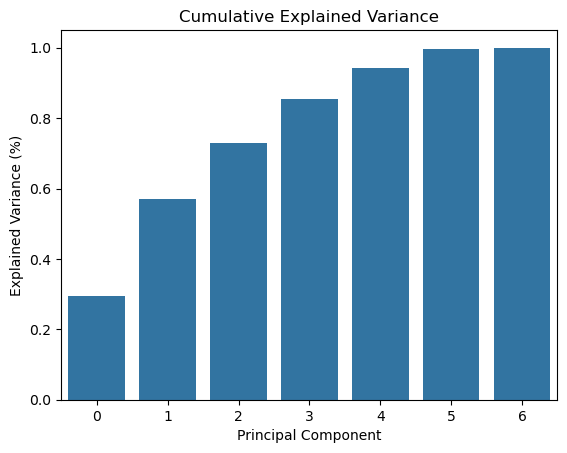

In [155]:
#Graphical representation of PCs' cumulative variance ratio
sns.barplot(data=cum_variance)
plt.title('Cumulative Explained Variance')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance (%)')
plt.show()

In [156]:
print(f'the cumulative explained variance of the first 2 PCs is: {cum_variance[1]:.2f}')

the cumulative explained variance of the first 2 PCs is: 0.57


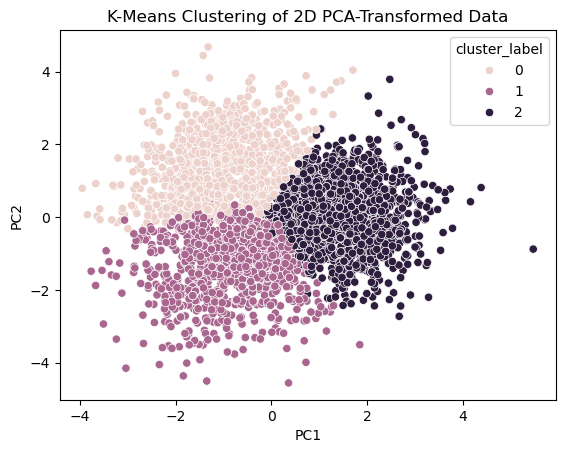

In [158]:
#look at clusters in 2D, with clustering with 2 components
sns.scatterplot(data=Products_pca, x=Products_pca[0], y=Products_pca[1], hue=Products_trans_scaled['cluster_label'])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('K-Means Clustering of 2D PCA-Transformed Data')
plt.show()